### 1: Import Libraries


In [7]:
# Data manipulation and analysis
import numpy as np
import pandas as pd
from pathlib import Path

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
plt.style.use('fivethirtyeight')

# Feature engineering
import ta  # Technical analysis library
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA

# Machine learning models (Regression)
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

# Deep learning
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, LSTM, Dropout, Input, Concatenate
from tensorflow.keras.callbacks import EarlyStopping

# Model evaluation
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from math import sqrt

# Model interpretation
import shap

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

### 2: Load and Explore Dataset

Dataset shape: (1989, 14)

First 5 rows:
         Date          Open          High           Low         Close  \
0  2016-07-01  17924.240234  18002.380859  17916.910156  17949.369141   
1  2016-06-30  17712.759766  17930.609375  17711.800781  17929.990234   
2  2016-06-29  17456.019531  17704.509766  17456.019531  17694.679688   
3  2016-06-28  17190.509766  17409.720703  17190.509766  17409.720703   
4  2016-06-27  17355.210938  17355.210938  17063.080078  17140.240234   

      Volume     Adj Close  Volatility  news_sentiment  Label  \
0   82160000  17949.369141         NaN       -0.400000      1   
1  133030000  17929.990234         NaN       -0.400000      1   
2  106380000  17694.679688         NaN        0.675447      1   
3  112190000  17409.720703         NaN       -0.307364      1   
4  138740000  17140.240234         NaN       -0.308320      0   

   reddit_sentiment  Target  pct_change  final_sentiment  
0          0.141433       0         NaN        -0.258567  
1          

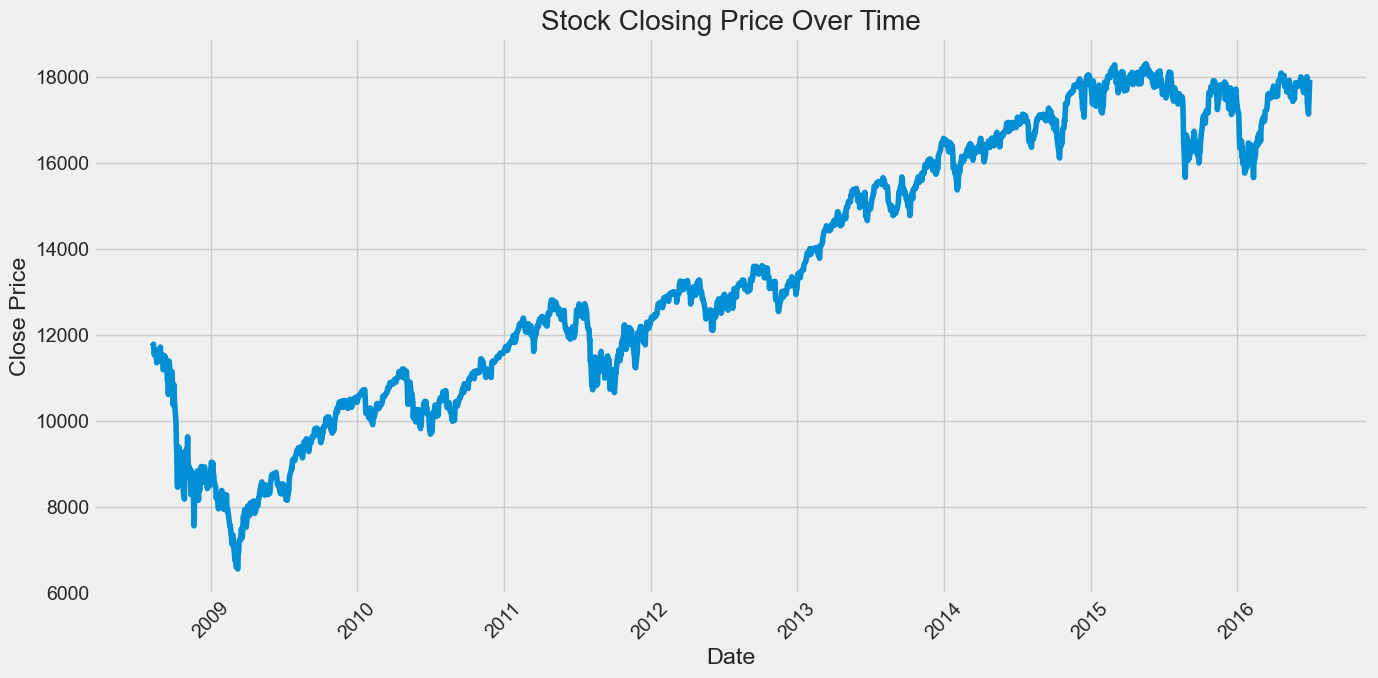

In [8]:
dataset_path = Path("B:/Dublin City University/Practicum/Proj/Dataset/main/processed/multimodal_dataset_final2.csv")

df = pd.read_csv(dataset_path)

print(f"Dataset shape: {df.shape}")
print("\nFirst 5 rows:")
print(df.head())

missing_values = df.isnull().sum()
print("\nMissing values per column:")
print(missing_values[missing_values > 0])

print("\nDataset statistics:")
print(df.describe())

print("\nColumn data types:")
print(df.dtypes)

if 'Close' in df.columns and 'Date' in df.columns:
    plt.figure(figsize=(14, 7))
    plt.plot(pd.to_datetime(df['Date']), df['Close'])
    plt.title('Stock Closing Price Over Time')
    plt.xlabel('Date')
    plt.ylabel('Close Price')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

### 3: Data Preprocessing

In [9]:
# Convert Date column to datetime if it exists
if 'Date' in df.columns:
    df['Date'] = pd.to_datetime(df['Date'])
    # Set Date as index for time-series analysis
    df.set_index('Date', inplace=True)
    
# Handle missing values as mentioned in the project plan
# For volatility, fill missing values with the mean
if 'volatility' in df.columns and df['volatility'].isnull().sum() > 0:
    df['volatility'].fillna(df['volatility'].mean(), inplace=True)

# Fill missing pct_change with 0 for the first row
if 'pct_change' in df.columns and df['pct_change'].isnull().sum() > 0:
    df['pct_change'].fillna(0, inplace=True)

# Check if we successfully handled missing values
print("Remaining missing values:")
print(df.isnull().sum()[df.isnull().sum() > 0])

# Define target variable as 'Close' price
target_col = 'Close'
if target_col not in df.columns:
    raise ValueError(f"Target column '{target_col}' not found in dataframe")

# Display information about target variable
print(f"\nTarget variable '{target_col}' statistics:")
print(df[target_col].describe())

# Let's create a next day's closing price as our actual prediction target
df['Next_Close'] = df[target_col].shift(-1)
print("\nCreated 'Next_Close' column for prediction target")
print(df[['Close', 'Next_Close']].head())

Remaining missing values:
Volatility    9
dtype: int64

Target variable 'Close' statistics:
count     1989.000000
mean     13463.032255
std       3144.006996
min       6547.049805
25%      10913.379883
50%      13025.580078
75%      16478.410156
max      18312.390625
Name: Close, dtype: float64

Created 'Next_Close' column for prediction target
                   Close    Next_Close
Date                                  
2016-07-01  17949.369141  17929.990234
2016-06-30  17929.990234  17694.679688
2016-06-29  17694.679688  17409.720703
2016-06-28  17409.720703  17140.240234
2016-06-27  17140.240234  17400.750000


C:\Users\abhis\AppData\Local\Temp\ipykernel_24736\1113567748.py:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['pct_change'].fillna(0, inplace=True)


### 4: Feature Engineering

C:\Users\abhis\AppData\Local\Temp\ipykernel_24736\2715393979.py:57: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_with_indicators.fillna(method='ffill', inplace=True)
C:\Users\abhis\AppData\Local\Temp\ipykernel_24736\2715393979.py:59: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_with_indicators.fillna(method='bfill', inplace=True)


Dataset shape after adding technical indicators: (1989, 36)
                    Open          High           Low         Close     Volume  \
Date                                                                            
2016-07-01  17924.240234  18002.380859  17916.910156  17949.369141   82160000   
2016-06-30  17712.759766  17930.609375  17711.800781  17929.990234  133030000   
2016-06-29  17456.019531  17704.509766  17456.019531  17694.679688  106380000   
2016-06-28  17190.509766  17409.720703  17190.509766  17409.720703  112190000   
2016-06-27  17355.210938  17355.210938  17063.080078  17140.240234  138740000   

               Adj Close  Volatility  news_sentiment  Label  reddit_sentiment  \
Date                                                                            
2016-07-01  17949.369141  285.412085       -0.400000      1          0.141433   
2016-06-30  17929.990234  285.412085       -0.400000      1          0.357038   
2016-06-29  17694.679688  285.412085        0.67

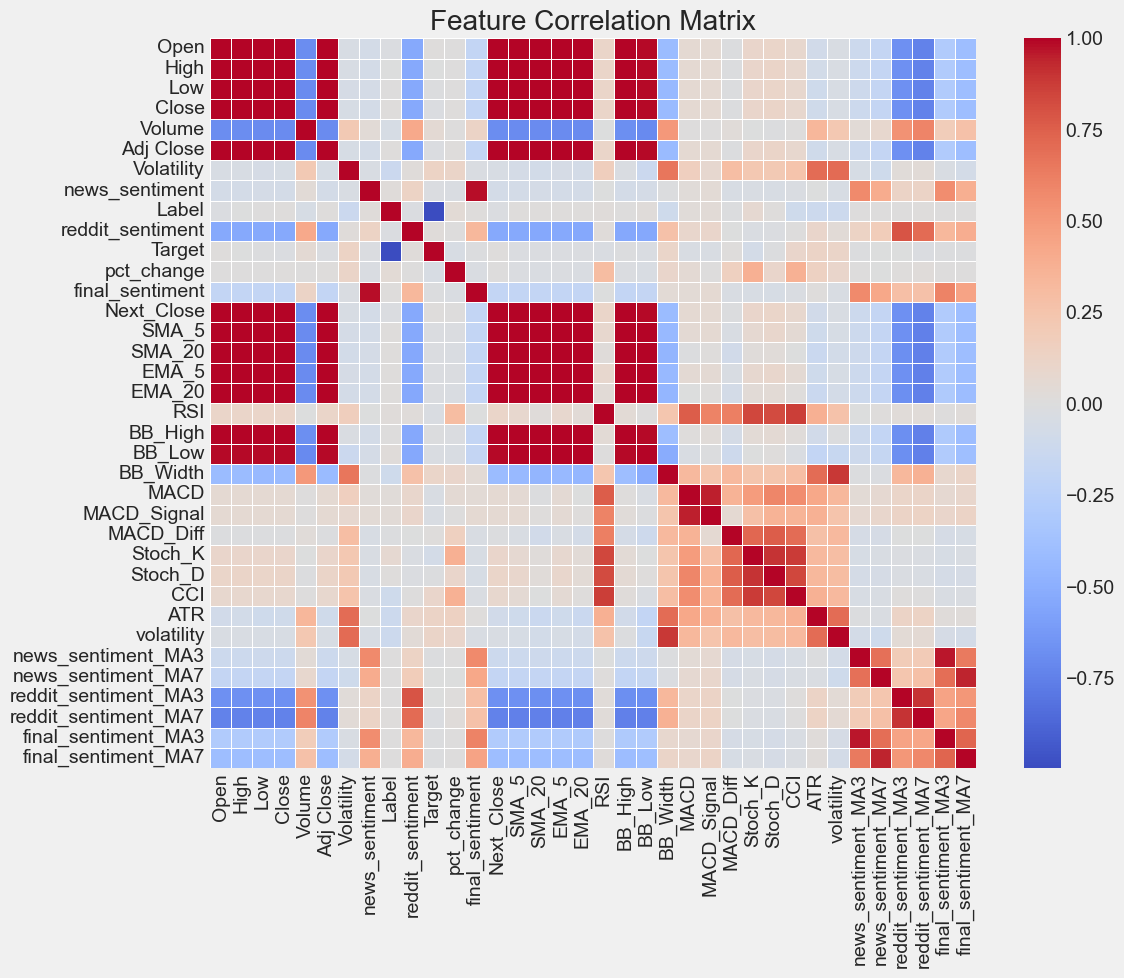

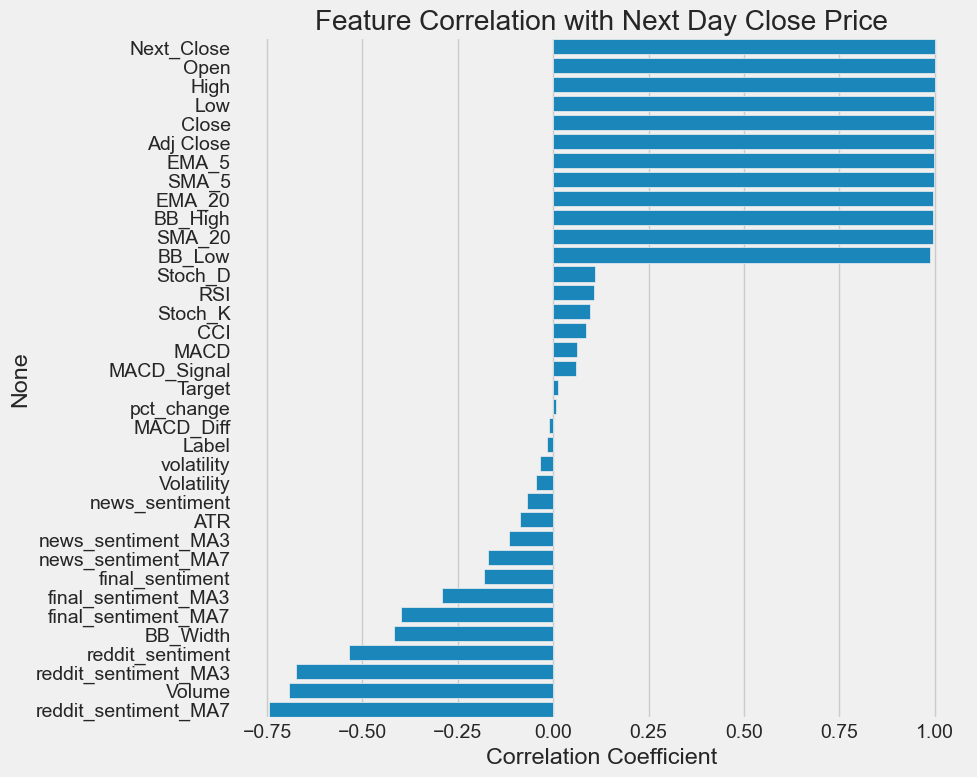

In [ ]:
# Function to add technical indicators
def add_technical_indicators(df):
    """Add technical indicators to the dataframe."""
    df_new = df.copy()
    
    if all(col in df.columns for col in ['Open', 'High', 'Low', 'Close', 'Volume']):
        # Add Moving Averages
        df_new['SMA_5'] = ta.trend.sma_indicator(df_new['Close'], window=5)
        df_new['SMA_20'] = ta.trend.sma_indicator(df_new['Close'], window=20)
        df_new['EMA_5'] = ta.trend.ema_indicator(df_new['Close'], window=5)
        df_new['EMA_20'] = ta.trend.ema_indicator(df_new['Close'], window=20)
        
        # Add RSI (Relative Strength Index)
        df_new['RSI'] = ta.momentum.rsi(df_new['Close'], window=14)
        
        # Add Bollinger Bands
        bollinger = ta.volatility.BollingerBands(df_new['Close'], window=20, window_dev=2)
        df_new['BB_High'] = bollinger.bollinger_hband()
        df_new['BB_Low'] = bollinger.bollinger_lband()
        df_new['BB_Width'] = bollinger.bollinger_wband()
        
        # Add MACD
        macd = ta.trend.MACD(df_new['Close'])
        df_new['MACD'] = macd.macd()
        df_new['MACD_Signal'] = macd.macd_signal()
        df_new['MACD_Diff'] = macd.macd_diff()
        
        # Add Stochastic Oscillator
        stoch = ta.momentum.StochasticOscillator(df_new['High'], df_new['Low'], df_new['Close'])
        df_new['Stoch_K'] = stoch.stoch()
        df_new['Stoch_D'] = stoch.stoch_signal()
        
        # Add Commodity Channel Index
        df_new['CCI'] = ta.trend.cci(df_new['High'], df_new['Low'], df_new['Close'])
        
        # Add Average True Range for volatility
        df_new['ATR'] = ta.volatility.average_true_range(df_new['High'], df_new['Low'], df_new['Close'])
    
    return df_new

# Apply feature engineering
df_with_indicators = add_technical_indicators(df)

# Add rolling volatility if not present
if 'volatility' not in df_with_indicators.columns and 'Close' in df_with_indicators.columns:
    df_with_indicators['volatility'] = df_with_indicators['Close'].rolling(window=20).std()

# Sentiment smoothing - apply rolling average to sentiment scores
# Adjust the column names as needed based on your actual dataset
sentiment_cols = [col for col in df.columns if any(s in col.lower() for s in ['sentiment', 'reddit', 'news'])]
for col in sentiment_cols:
    df_with_indicators[f'{col}_MA3'] = df_with_indicators[col].rolling(window=3).mean()
    df_with_indicators[f'{col}_MA7'] = df_with_indicators[col].rolling(window=7).mean()

# Forward fill NaN values created by rolling operations
df_with_indicators.fillna(method='ffill', inplace=True)
# For any remaining NaNs at the beginning, backfill
df_with_indicators.fillna(method='bfill', inplace=True)

# Drop the last row since Next_Close will be NaN
df_with_indicators = df_with_indicators.dropna(subset=['Next_Close'])

# Show the new dataset with technical indicators
print("Dataset shape after adding technical indicators:", df_with_indicators.shape)
print(df_with_indicators.head())

# Check for multicollinearity using correlation matrix
correlation_matrix = df_with_indicators.corr()

# Visualize correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', linewidths=0.5)
plt.title('Feature Correlation Matrix')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Visualize correlation with target variable (Next_Close)
target_corr = correlation_matrix['Next_Close'].sort_values(ascending=False)
plt.figure(figsize=(10, 8))
sns.barplot(x=target_corr.values, y=target_corr.index)
plt.title('Feature Correlation with Next Day Close Price')
plt.xlabel('Correlation Coefficient')
plt.tight_layout()
plt.show()

### 5: Feature Selection and Data Preparation

In [11]:
# Optionally perform PCA to reduce dimensionality if we have too many correlated features
def perform_pca(X, n_components=0.95):
    """Perform PCA to reduce dimensionality."""
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    pca = PCA(n_components=n_components)  # Keep components that explain 95% of variance
    X_pca = pca.fit_transform(X_scaled)
    
    print(f"Original features: {X.shape[1]}")
    print(f"PCA features: {X_pca.shape[1]}")
    print(f"Explained variance ratio: {sum(pca.explained_variance_ratio_):.4f}")
    
    return X_pca, pca, scaler

# Prepare data for modeling
def prepare_data(df, target_col='Next_Close', time_steps=10, test_size=0.2):
    """Prepare data for time series modeling."""
    # Drop rows with NaN values
    df = df.dropna()
    
    # Define features and target
    if target_col in df.columns:
        y = df[target_col].values
        X = df.drop([target_col], axis=1)
        
        # Also remove Close price column if predicting Next_Close
        if target_col == 'Next_Close' and 'Close' in X.columns:
            print("Keeping 'Close' as a feature since we're predicting Next_Close")
    else:
        raise ValueError(f"Target column '{target_col}' not found in dataframe")
    
    # Split data into training and testing sets (time-series aware)
    split_idx = int(len(df) * (1 - test_size))
    
    X_train = X.iloc[:split_idx]
    X_test = X.iloc[split_idx:]
    y_train = y[:split_idx]
    y_test = y[split_idx:]
    
    # Scale the features
    feature_scaler = StandardScaler()
    X_train_scaled = feature_scaler.fit_transform(X_train)
    X_test_scaled = feature_scaler.transform(X_test)
    
    # Scale the target variable separately
    target_scaler = StandardScaler()
    y_train_scaled = target_scaler.fit_transform(y_train.reshape(-1, 1)).flatten()
    y_test_scaled = target_scaler.transform(y_test.reshape(-1, 1)).flatten()
    
    # For LSTM: reshape data into samples, time steps, and features
    def create_sequences(X, y, time_steps):
        X_seq, y_seq = [], []
        for i in range(len(X) - time_steps):
            X_seq.append(X[i:i + time_steps])
            y_seq.append(y[i + time_steps])
        return np.array(X_seq), np.array(y_seq)
    
    # Create sequences for LSTM
    X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, time_steps)
    X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test_scaled, time_steps)
    
    print(f"Training data shape: {X_train.shape}, Testing data shape: {X_test.shape}")
    print(f"LSTM training data shape: {X_train_seq.shape}, LSTM testing data shape: {X_test_seq.shape}")
    
    return {
        'regular': (X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled),
        'lstm': (X_train_seq, X_test_seq, y_train_seq, y_test_seq),
        'feature_scaler': feature_scaler,
        'target_scaler': target_scaler,
        'feature_names': X.columns.tolist(),
        'original_y_test': y_test
    }

# Split features into categories for multimodal analysis
def split_features_by_type(df):
    """Split features into market data, technical indicators, and sentiment."""
    market_data_cols = ['Open', 'High', 'Low', 'Close', 'Volume', 'pct_change', 'volatility']
    market_data_cols = [col for col in market_data_cols if col in df.columns]
    
    technical_cols = [col for col in df.columns if any(
        s in col for s in ['SMA', 'EMA', 'RSI', 'BB_', 'MACD', 'Stoch', 'CCI', 'ATR']
    )]
    
    sentiment_cols = [col for col in df.columns if any(
        s in col.lower() for s in ['sentiment', 'reddit', 'news']
    )]
    
    return {
        'market_data': market_data_cols,
        'technical': technical_cols,
        'sentiment': sentiment_cols
    }

# Apply the functions
feature_categories = split_features_by_type(df_with_indicators)
print("Feature categories:")
for category, cols in feature_categories.items():
    print(f"{category}: {len(cols)} features")
    print(cols[:5], "..." if len(cols) > 5 else "")

# Prepare the data for modeling
data = prepare_data(df_with_indicators, target_col='Next_Close', time_steps=10)

Feature categories:
market_data: 7 features
['Open', 'High', 'Low', 'Close', 'Volume'] ...
technical: 15 features
['SMA_5', 'SMA_20', 'EMA_5', 'EMA_20', 'RSI'] ...
sentiment: 9 features
['news_sentiment', 'reddit_sentiment', 'final_sentiment', 'news_sentiment_MA3', 'news_sentiment_MA7'] ...
Keeping 'Close' as a feature since we're predicting Next_Close
Training data shape: (1591, 35), Testing data shape: (398, 35)
LSTM training data shape: (1581, 10, 35), LSTM testing data shape: (388, 10, 35)


### 6: Baseline Regression Models

Training Linear Regression...
Training Ridge Regression...
Training Random Forest Regressor...
Training XGBoost Regressor...

Baseline Model Results (Original Scale):
               Model           MSE         RMSE         MAE        R2  \
0  Linear Regression  2.550559e+02    15.970468    3.934646  0.999814   
1   Ridge Regression  1.865909e+03    43.196163   27.932745  0.998640   
2      Random Forest  1.337136e+06  1156.345981  807.670233  0.025736   
3            XGBoost  1.424855e+06  1193.672993  851.391308 -0.038178   

    MAPE (%)  
0   0.041264  
1   0.310962  
2   9.991341  
3  10.484161  


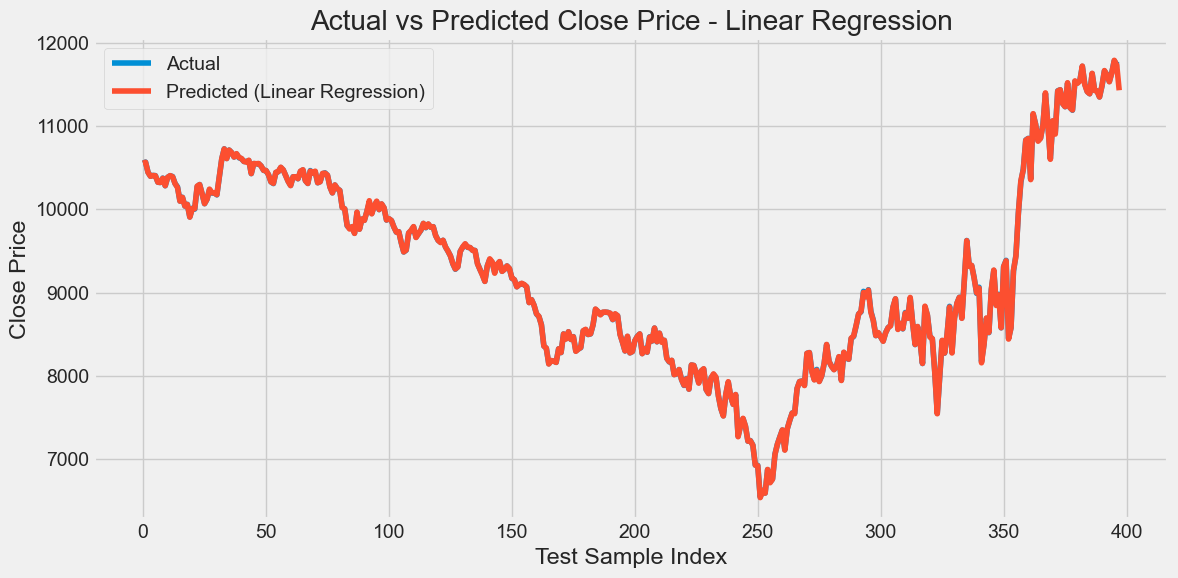

In [12]:
# Define function to measure regression performance
def evaluate_regression(y_true, y_pred, scaler=None):
    """Evaluate regression model performance."""
    # If data was scaled, we should convert predictions back to original scale
    if scaler is not None:
        y_true = scaler.inverse_transform(y_true.reshape(-1, 1)).flatten()
        y_pred = scaler.inverse_transform(y_pred.reshape(-1, 1)).flatten()
    
    # Calculate metrics
    mse = mean_squared_error(y_true, y_pred)
    rmse = sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    # Mean percentage error
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    
    return {
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'R2': r2,
        'MAPE': mape
    }

# Implement baseline regression models
def train_evaluate_baseline_regression_models(data):
    """Train and evaluate baseline regression models."""
    X_train, X_test, y_train, y_test = data['regular']
    target_scaler = data['target_scaler']
    original_y_test = data['original_y_test']
    
    # List to store model results
    results = []
    
    # 1. Linear Regression
    print("Training Linear Regression...")
    lr = LinearRegression()
    lr.fit(X_train, y_train)
    y_pred_lr = lr.predict(X_test)
    
    # Evaluate on scaled data
    lr_metrics = evaluate_regression(y_test, y_pred_lr)
    
    # Convert predictions back to original scale for interpretability
    y_pred_lr_original = target_scaler.inverse_transform(y_pred_lr.reshape(-1, 1)).flatten()
    lr_metrics_original = evaluate_regression(original_y_test, y_pred_lr_original)
    
    results.append({
        'model': 'Linear Regression',
        'metrics_scaled': lr_metrics,
        'metrics_original': lr_metrics_original,
        'model_obj': lr
    })
    
    # 2. Ridge Regression
    print("Training Ridge Regression...")
    ridge = Ridge(alpha=1.0)
    ridge.fit(X_train, y_train)
    y_pred_ridge = ridge.predict(X_test)
    
    # Evaluate on scaled data
    ridge_metrics = evaluate_regression(y_test, y_pred_ridge)
    
    # Convert predictions back to original scale
    y_pred_ridge_original = target_scaler.inverse_transform(y_pred_ridge.reshape(-1, 1)).flatten()
    ridge_metrics_original = evaluate_regression(original_y_test, y_pred_ridge_original)
    
    results.append({
        'model': 'Ridge Regression',
        'metrics_scaled': ridge_metrics,
        'metrics_original': ridge_metrics_original,
        'model_obj': ridge
    })
    
    # 3. Random Forest Regressor
    print("Training Random Forest Regressor...")
    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(X_train, y_train)
    y_pred_rf = rf.predict(X_test)
    
    # Evaluate on scaled data
    rf_metrics = evaluate_regression(y_test, y_pred_rf)
    
    # Convert predictions back to original scale
    y_pred_rf_original = target_scaler.inverse_transform(y_pred_rf.reshape(-1, 1)).flatten()
    rf_metrics_original = evaluate_regression(original_y_test, y_pred_rf_original)
    
    results.append({
        'model': 'Random Forest',
        'metrics_scaled': rf_metrics,
        'metrics_original': rf_metrics_original,
        'model_obj': rf
    })
    
    # 4. XGBoost Regressor
    print("Training XGBoost Regressor...")
    xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
    xgb_model.fit(X_train, y_train)
    y_pred_xgb = xgb_model.predict(X_test)
    
    # Evaluate on scaled data
    xgb_metrics = evaluate_regression(y_test, y_pred_xgb)
    
    # Convert predictions back to original scale
    y_pred_xgb_original = target_scaler.inverse_transform(y_pred_xgb.reshape(-1, 1)).flatten()
    xgb_metrics_original = evaluate_regression(original_y_test, y_pred_xgb_original)
    
    results.append({
        'model': 'XGBoost',
        'metrics_scaled': xgb_metrics,
        'metrics_original': xgb_metrics_original,
        'model_obj': xgb_model
    })
    
    # Display results
    results_df = pd.DataFrame([
        {
            'Model': r['model'],
            'MSE': r['metrics_original']['MSE'],
            'RMSE': r['metrics_original']['RMSE'],
            'MAE': r['metrics_original']['MAE'],
            'R2': r['metrics_original']['R2'],
            'MAPE (%)': r['metrics_original']['MAPE']
        } 
        for r in results
    ])
    
    print("\nBaseline Model Results (Original Scale):")
    print(results_df)
    
    # Plot actual vs predicted for the best model
    best_model_idx = results_df['R2'].argmax()
    best_model = results[best_model_idx]['model']
    best_predictions = None
    
    if best_model == 'Linear Regression':
        best_predictions = y_pred_lr_original
    elif best_model == 'Ridge Regression':
        best_predictions = y_pred_ridge_original
    elif best_model == 'Random Forest':
        best_predictions = y_pred_rf_original
    elif best_model == 'XGBoost':
        best_predictions = y_pred_xgb_original
    
    # Plot actual vs predicted values
    plt.figure(figsize=(12, 6))
    plt.plot(original_y_test, label='Actual')
    plt.plot(best_predictions, label=f'Predicted ({best_model})')
    plt.title(f'Actual vs Predicted Close Price - {best_model}')
    plt.xlabel('Test Sample Index')
    plt.ylabel('Close Price')
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    # Plot feature importance for the best tree-based model
    if best_model in ['Random Forest', 'XGBoost']:
        feature_names = data['feature_names']
        if best_model == 'Random Forest':
            importances = results[best_model_idx]['model_obj'].feature_importances_
        else:
            importances = results[best_model_idx]['model_obj'].feature_importances_
        
        # Create a DataFrame for better visualization
        feature_importance = pd.DataFrame({
            'Feature': feature_names,
            'Importance': importances
        }).sort_values('Importance', ascending=False)
        
        # Plot top 15 features
        plt.figure(figsize=(10, 8))
        sns.barplot(x='Importance', y='Feature', data=feature_importance.head(15))
        plt.title(f'Feature Importance - {best_model}')
        plt.tight_layout()
        plt.show()
    
    # Return the results for further analysis
    return {
        'results_df': results_df,
        'model_objects': {r['model']: r['model_obj'] for r in results},
        'predictions': {
            'Linear Regression': y_pred_lr_original,
            'Ridge Regression': y_pred_ridge_original,
            'Random Forest': y_pred_rf_original,
            'XGBoost': y_pred_xgb_original
        },
        'actual': original_y_test,
        'best_model': best_model
    }

# Train and evaluate baseline regression models
baseline_results = train_evaluate_baseline_regression_models(data)

### 7: LSTM Regression model

Training LSTM regression model...


C:\Users\abhis\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.5317 - mae: 0.5540 - val_loss: 0.1210 - val_mae: 0.2873
Epoch 2/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0296 - mae: 0.1338 - val_loss: 0.1448 - val_mae: 0.3133
Epoch 3/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0220 - mae: 0.1165 - val_loss: 0.1632 - val_mae: 0.3351
Epoch 4/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0190 - mae: 0.1080 - val_loss: 0.1426 - val_mae: 0.3169
Epoch 5/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0178 - mae: 0.1050 - val_loss: 0.1626 - val_mae: 0.3397
Epoch 6/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0157 - mae: 0.0983 - val_loss: 0.1687 - val_mae: 0.3454
Epoch 7/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0153 - mae: 0.0936 - val_loss: 0.1407 - val_mae: 0.3145
Epoch 8/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0137 - mae: 0.0914 - val_loss: 0.1239 - val_mae: 0.2952
Epoch 9/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0147 - ma

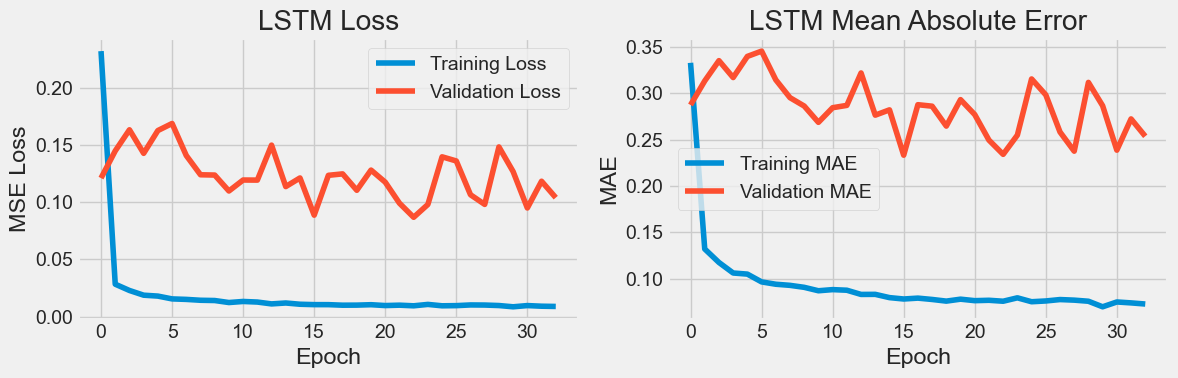

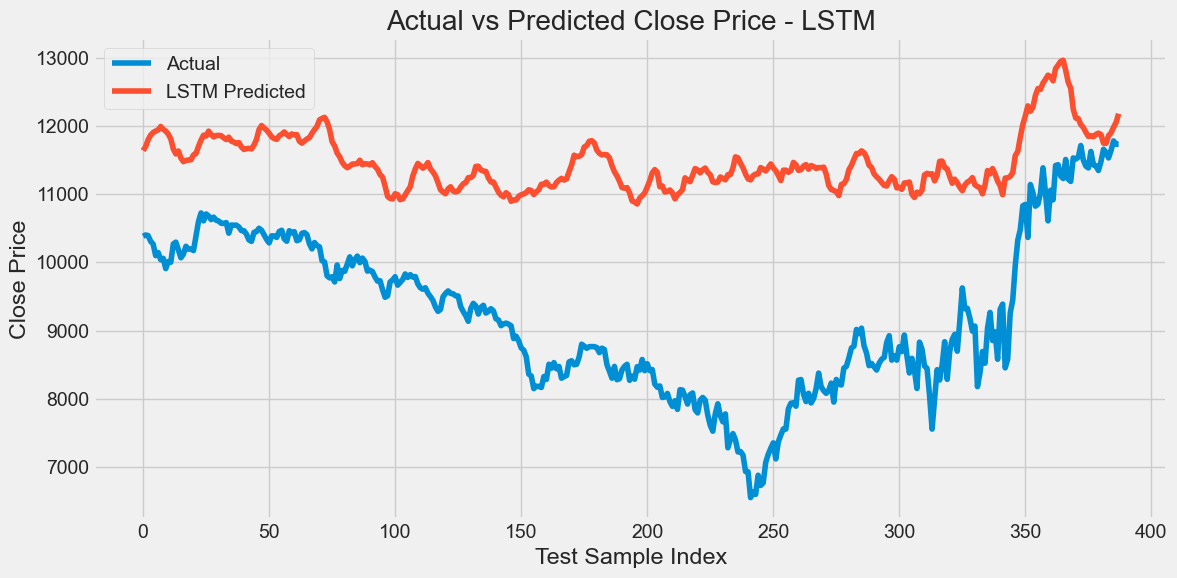

In [13]:
# Build LSTM Regression model
def build_lstm_regression_model(input_shape, lstm_units=50, dropout_rate=0.2):
    """Build an LSTM model for regression."""
    model = Sequential([
        LSTM(units=lstm_units, return_sequences=True, input_shape=input_shape),
        Dropout(dropout_rate),
        LSTM(units=lstm_units),
        Dropout(dropout_rate),
        Dense(1)  # No activation for regression
    ])
    
    model.compile(
        optimizer='adam',
        loss='mse',
        metrics=['mae']
    )
    
    return model

# Train and evaluate LSTM regression model
def train_evaluate_lstm_regression(data, epochs=50, batch_size=32):
    """Train and evaluate LSTM regression model."""
    X_train_seq, X_test_seq, y_train_seq, y_test_seq = data['lstm']
    target_scaler = data['target_scaler']
    original_y_test = data['original_y_test']
    
    # Adjust original_y_test to match the sequence length
    # LSTM sequences are shorter due to the time_steps parameter
    original_y_test_seq = original_y_test[-len(y_test_seq):]
    
    # Build and train the LSTM regression model
    print("Training LSTM regression model...")
    input_shape = (X_train_seq.shape[1], X_train_seq.shape[2])
    lstm_model = build_lstm_regression_model(input_shape)
    
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True
    )
    
    history = lstm_model.fit(
        X_train_seq, y_train_seq,
        epochs=epochs,
        batch_size=batch_size,
        validation_split=0.2,
        callbacks=[early_stopping],
        verbose=1
    )
    
    # Make predictions
    y_pred_scaled = lstm_model.predict(X_test_seq).flatten()
    
    # Calculate metrics on scaled data
    lstm_metrics_scaled = evaluate_regression(y_test_seq, y_pred_scaled)
    
    # Convert predictions back to original scale
    y_pred_original = target_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
    lstm_metrics_original = evaluate_regression(original_y_test_seq, y_pred_original)
    
    print("\nLSTM Regression Model Results (Original Scale):")
    for metric, value in lstm_metrics_original.items():
        print(f"{metric}: {value:.4f}")
    
    # Plot training history
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('LSTM Loss')
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['mae'], label='Training MAE')
    plt.plot(history.history['val_mae'], label='Validation MAE')
    plt.title('LSTM Mean Absolute Error')
    plt.xlabel('Epoch')
    plt.ylabel('MAE')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Plot actual vs predicted values
    plt.figure(figsize=(12, 6))
    plt.plot(original_y_test_seq, label='Actual')
    plt.plot(y_pred_original, label='LSTM Predicted')
    plt.title('Actual vs Predicted Close Price - LSTM')
    plt.xlabel('Test Sample Index')
    plt.ylabel('Close Price')
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    # Return the model and results
    return {
        'model': lstm_model,
        'history': history.history,
        'metrics_scaled': lstm_metrics_scaled,
        'metrics_original': lstm_metrics_original,
        'predictions': {
            'scaled': y_pred_scaled,
            'original': y_pred_original
        },
        'actual': original_y_test_seq
    }

# Train and evaluate LSTM regression model
lstm_results = train_evaluate_lstm_regression(data)

### 8: Multimodal LSTM Regression

In [ ]:
# Prepare data for multimodal LSTM regression
def prepare_multimodal_regression_data(df, feature_categories, target_col='Next_Close', time_steps=10, test_size=0.2):
    """Prepare data for multimodal LSTM regression."""
    # Drop rows with NaN values
    df = df.dropna()
    
    # Define target
    if target_col in df.columns:
        y = df[target_col].values
    else:
        raise ValueError(f"Target column '{target_col}' not found in dataframe")
    
    # Split features by category
    market_cols = feature_categories['market_data']
    technical_cols = feature_categories['technical'] 
    sentiment_cols = feature_categories['sentiment']
    
    # Extract feature sets
    X_market = df[market_cols].values
    X_technical = df[technical_cols].values
    X_sentiment = df[sentiment_cols].values
    
    # Split data (time-series aware)
    split_idx = int(len(df) * (1 - test_size))
    
    X_market_train = X_market[:split_idx]
    X_market_test = X_market[split_idx:]
    
    X_technical_train = X_technical[:split_idx]
    X_technical_test = X_technical[split_idx:]
    
    X_sentiment_train = X_sentiment[:split_idx]
    X_sentiment_test = X_sentiment[split_idx:]
    
    y_train = y[:split_idx]
    y_test = y[split_idx:]
    
    # Scale the features
    market_scaler = StandardScaler()
    technical_scaler = StandardScaler()
    sentiment_scaler = StandardScaler()
    
    X_market_train_scaled = market_scaler.fit_transform(X_market_train)
    X_market_test_scaled = market_scaler.transform(X_market_test)
    
    X_technical_train_scaled = technical_scaler.fit_transform(X_technical_train)
    X_technical_test_scaled = technical_scaler.transform(X_technical_test)
    
    X_sentiment_train_scaled = sentiment_scaler.fit_transform(X_sentiment_train)
    X_sentiment_test_scaled = sentiment_scaler.transform(X_sentiment_test)
    
    # Scale the target variable separately
    target_scaler = StandardScaler()
    y_train_scaled = target_scaler.fit_transform(y_train.reshape(-1, 1)).flatten()
    y_test_scaled = target_scaler.transform(y_test.reshape(-1, 1)).flatten()
    
    # Function to create sequences for LSTM
    def create_sequences(X, y, time_steps):
        X_seq, y_seq = [], []
        for i in range(len(X) - time_steps):
            X_seq.append(X[i:i + time_steps])
            y_seq.append(y[i + time_steps])
        return np.array(X_seq), np.array(y_seq)
    
    # Create sequences
    X_market_train_seq, y_market_train_seq = create_sequences(X_market_train_scaled, y_train_scaled, time_steps)
    X_market_test_seq, y_market_test_seq = create_sequences(X_market_test_scaled, y_test_scaled, time_steps)
    
    X_technical_train_seq, _ = create_sequences(X_technical_train_scaled, y_train_scaled, time_steps)
    X_technical_test_seq, _ = create_sequences(X_technical_test_scaled, y_test_scaled, time_steps)
    
    X_sentiment_train_seq, _ = create_sequences(X_sentiment_train_scaled, y_train_scaled, time_steps)
    X_sentiment_test_seq, _ = create_sequences(X_sentiment_test_scaled, y_test_scaled, time_steps)
    
    # Ensure all sequences have the same length
    min_len = min(len(y_market_train_seq), len(y_market_train_seq))
    
    X_market_train_seq = X_market_train_seq[:min_len]
    X_technical_train_seq = X_technical_train_seq[:min_len]
    X_sentiment_train_seq = X_